# Projet 6 - Feature image

In [1]:
!pip install pandas matplotlib numpy seaborn scikit-learn missingno plotly nltk gensim transformers torch tensorflow_hub opencv-python
!pip freeze > requirements.txt

In [2]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.3.1
anyio                     4.12.0
appnope                   0.1.4
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.4.0
asttokens                 3.0.1
astunparse                1.6.3
async-lru                 2.0.5
attrs                     25.4.0
babel                     2.17.0
beautifulsoup4            4.14.3
bleach                    6.3.0
certifi                   2025.11.12
cffi                      2.0.0
charset-normalizer        3.4.4
click                     8.1.8
comm                      0.2.3
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.17
decorator                 5.2.1
defusedxml                0.7.1
entrypoints               0.4
executing                 2.2.1
fastjsonschema            2.21.2
filelock                  3.20.0
flatbuffers               25.9.23
fonttools        

## Import des librairies et du dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import cv2


import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import time
from PIL import Image


# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [26]:
data = pd.read_csv('data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df = data.copy()
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
677,5518124b75d6c6dfee4c2e4c0cfa716a,2015-12-31 09:19:31 +0000,http://www.flipkart.com/simoco-7-w-9-12-w-led-...,"Simoco 7 W, 9 W, 12 W LED Bulb","[""Kitchen & Dining >> Lighting >> Bulbs >> Sim...",BLBEEB6HBDZGRHE9,897.0,829.0,5518124b75d6c6dfee4c2e4c0cfa716a.jpg,False,"Buy Simoco 7 W, 9 W, 12 W LED Bulb for Rs.829 ...",No rating available,No rating available,Simoco,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
143,a1fd886094826c3f25c6ffb380073974,2015-12-01 12:40:44 +0000,http://www.flipkart.com/prithish-warm-up-evil-...,Prithish Warm Up The Evil In Me Double Color C...,"[""Kitchen & Dining >> Coffee Mugs >> Prithish ...",MUGECEVFZVB49B8S,599.0,225.0,a1fd886094826c3f25c6ffb380073974.jpg,False,Buy Prithish Warm Up The Evil In Me Double Col...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
506,8ccc970bf4c55e9b2710d5319161c357,2016-01-07 05:50:25 +0000,http://www.flipkart.com/rega-gateway-md7822-md...,Rega IT Gateway MD7822 MD-7822 MD7822U 6 Cell ...,"[""Computers >> Laptop Accessories >> Batteries...",ACCDXFP2HFYAWDBT,2699.0,1299.0,8ccc970bf4c55e9b2710d5319161c357.jpg,False,Buy Rega IT Gateway MD7822 MD-7822 MD7822U 6 C...,No rating available,No rating available,Rega IT,"{""product_specification""=>[{""key""=>""In The Box..."
914,762b6b22cccf91935e92446efe298fe3,2016-04-02 19:26:28 +0000,http://www.flipkart.com/612-league-baby-boy-s-...,612 League Baby Boy's Checkered Casual Shirt,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",SHTEFGCEGSYJT3MN,545.0,381.0,762b6b22cccf91935e92446efe298fe3.jpg,True,Specifications of 612 League Baby Boy's Checke...,No rating available,No rating available,612 League,"{""product_specification""=>[{""key""=>""Pattern"", ..."
629,9d3ca83f7017d6e9e129964e88503ff0,2016-06-23 23:50:58 +0000,http://www.flipkart.com/kushies-baby-girl-s-sh...,Kushies baby Baby Girl's Shrug,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",RUGEHCDG6DKDUCDZ,2199.0,2199.0,9d3ca83f7017d6e9e129964e88503ff0.jpg,False,Specifications of Kushies baby Baby Girl's Shr...,No rating available,No rating available,Kushies baby,"{""product_specification""=>[{""key""=>""Pattern"", ..."


## Création d'un dataframe contenant les images ainsi que leur nom et description

In [27]:
print(df['uniq_id'].nunique())
print(df['image'].nunique())

1050
1050


Il y a autant de valeurs uniques dans la colonne image que dans la colonne uniq_id. Cela signifie que l'ensemble des valeurs de la colonne image est unique et que donc on peut metrte les valeurs de la colonne image en index.

In [28]:
df = pd.read_csv("data/Flipkart/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'image',
                 encoding ='utf-8')

df_pict = df[['product_name', 'description']].copy('deep')
df_pict.sample(3)

,product_name,description
image,,
8284c10b2890ed53e17de5cfc33cdb96.jpg,Maxima 24990LMLI Swarovski Analog Watch - For...,Maxima 24990LMLI Swarovski Analog Watch - For...
705b90361aeda1849a728d80625a78a9.jpg,Marvel Cotton Bath Towel,Buy Marvel Cotton Bath Towel at Rs. 449 at Fli...
54749618b728306f9b3dc518dec315ee.jpg,Petrol PCWBL68 Analog Watch - For Men,Petrol PCWBL68 Analog Watch - For Men - Buy P...


On importe les images et on les met dans un dictionnaire

In [29]:
file_path = 'data/Flipkart/Images/complete_dataset'

li_files = df_pict.index

## importing pictures
dict_img_orig = {}

# loop on the pictures in the file
for i, ind in enumerate(li_files,1):
    print('\r', f"{i}/{len(list(li_files))}", end="")
    # cast each image to a np.array
    img = np.array(Image.open(os.path.join(file_path, ind)))

    # put in the dictionnary
    dict_img_orig[ind] = img


 678/1050

/Users/j/Documents/OC_Inge_IA/Projet_6_copie/.venv/lib/python3.11/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 1050/1050

In [30]:
df_pict.index

Index(['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
       '7b72c92c2f6c40268628ec5f14c6d590.jpg',
       '64d5d4a258243731dc7bbb1eef49ad74.jpg',
       'd4684dcdc759dd9cdf41504698d737d8.jpg',
       '6325b6870c54cd47be6ebfbffa620ec7.jpg',
       '893aa5ed55f7cff2eccea7758d7a86bd.jpg',
       'f355cc1ccb08bd0d283ed979b7ee7515.jpg',
       'dd0e3470a7e6ed76fd69c2da27721041.jpg',
       '41384da51732c0b4df3de8f395714fbb.jpg',
       '710ed5f2393a4b9e8823aa0029f71f93.jpg',
       ...
       '3b465b02720ef7c930cb2e065a8fc05d.jpg',
       'b1644f47c7dfa58f8c06677f2a27ee09.jpg',
       '057836ecde71565f8ebdd576e41fdc96.jpg',
       '38782cce965307ddcdbedfcb7fa409c3.jpg',
       'be0f39341d771aac57084970f1ed6425.jpg',
       '958f54f4c46b53c8a0a9b8167d9140bc.jpg',
       'fd6cbcc22efb6b761bd564c28928483c.jpg',
       '5912e037d12774bb73a2048f35a00009.jpg',
       'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg',
       'f2f027ad6a6df617c9f125173da71e44.jpg'],
      dtype='object', name='image', length=1050)

In [31]:
ser_img_orig = pd.Series(dict_img_orig,
                         index = df_pict.index,
                         name='img_orig')
df_pict = pd.concat([df_pict,
                     ser_img_orig.to_frame()], axis=1)

In [32]:
ser_img_orig

image
55b85ea15a1536d46b7190ad6fff8ce7.jpg    [[[192, 184, 173], [192, 184, 173], [193, 185,...
7b72c92c2f6c40268628ec5f14c6d590.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
64d5d4a258243731dc7bbb1eef49ad74.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
d4684dcdc759dd9cdf41504698d737d8.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
6325b6870c54cd47be6ebfbffa620ec7.jpg    [[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...
                                                              ...                        
958f54f4c46b53c8a0a9b8167d9140bc.jpg    [[[253, 253, 251], [255, 255, 253], [255, 255,...
fd6cbcc22efb6b761bd564c28928483c.jpg    [[[253, 216, 224], [253, 216, 224], [253, 216,...
5912e037d12774bb73a2048f35a00009.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
c3edc504d1b4f0ba6224fa53a43a7ad6.jpg    [[[52, 52, 54], [54, 54, 56], [51, 51, 53], [5...
f2f027ad6a6df617c9f125173da71e44.jpg    [[[241, 224, 232], [241, 224, 232], [241, 224,...
Name

In [33]:
df_pict

,product_name,description,img_orig
image,,,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[[[192, 184, 173], [192, 184, 173], [193, 185,..."
7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6..."
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,"[[[253, 253, 251], [255, 255, 253], [255, 255,..."
fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[[[253, 216, 224], [253, 216, 224], [253, 216,..."
5912e037d12774bb73a2048f35a00009.jpg,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


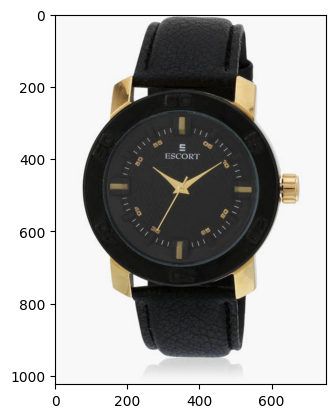

In [34]:
import matplotlib.pyplot as plt

for img in df_pict['img_orig'].iloc[15:16]:
    plt.imshow(img)
    plt.show()

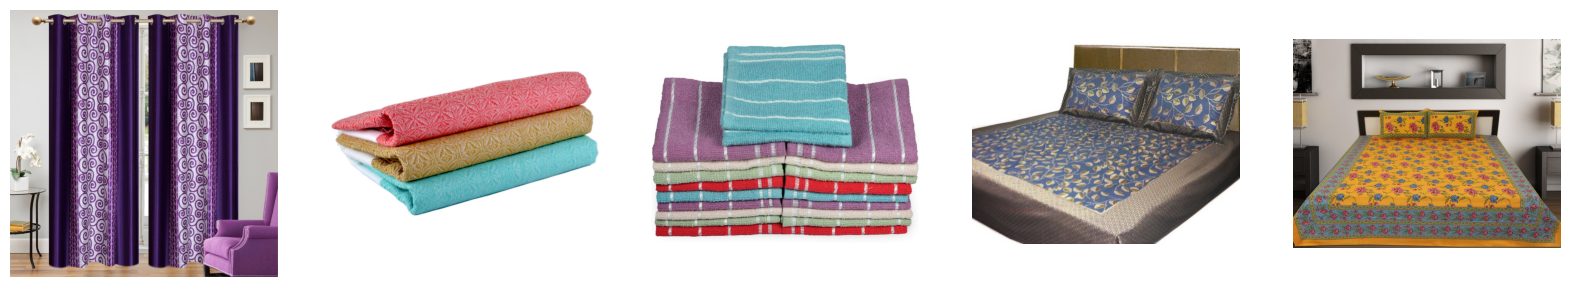

In [35]:
import matplotlib.pyplot as plt

# Get the first 5 images
images = df_pict['img_orig'].iloc[:5]

# Create a figure with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Loop through each image and its corresponding spot (axis)
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off') # Hides the axis numbers for a cleaner look

plt.show()

## Verifier si les images sont corrompues

# Plan du projet

Vérification corrélations champ manquant / duplicatas / images corrompues.  
Standardisation images (resize, normalisation pixel, vérification ratio / orientation).  

Méthodes classiques de features locaux : SIFT / ORB / SURF (bag-of-visual-words possible).  
Approche deep : CNN + Transfer Learning (ex. ResNet/Inception/EfficientNet → features intermédiaires).  

5. Analyse visuelle & conclusion de faisabilité
Observer regroupements par catégorie : cohérence, chevauchements, sous-groupes.
Évaluer si texte et/ou image suffisent (ou combinaison multimodale) pour séparer les catégories.
6. Mesure quantitative
Segmentation non supervisée (k-means, GMM, DBSCAN, etc.) → obtenir clusters.
Mesures de similarité entre catégories réelles et clusters : ARI (Adjusted Rand Index), AMI (Adjusted Mutual Info), Homogeneity / Completeness / V-measure, NMI.
Comparer performances selon features (image only, text only, multimodal concaténée / late fusion).

## Travail sur l'image

- resizing
- affichage des images

In [36]:
from PIL import Image
import os


def basic_image_check(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # What do you think this does?
        return True
    except Exception as e:
        print(f"Corrupted: {image_path} - {e}")
        return False

In [37]:

basic_image_check(file_path)

Corrupted: data/Flipkart/Images/complete_dataset - [Errno 21] Is a directory: 'data/Flipkart/Images/complete_dataset'


False

In [38]:
from PIL import Image
import os

def check_image_integrity(image_path):
    """
    Thoroughly check if an image is corrupted.
    Returns (is_valid, error_message)
    """
    try:
        # Step 1: Can we open it?
        img = Image.open(image_path)
        
        # Step 2: Verify the header
        img.verify()
        
        # Step 3: Actually load the image data
        # verify() closes the file, so we need to reopen
        img = Image.open(image_path)
        img.load()  # This forces PIL to decode the entire image
        
        return True, None
        
    except Exception as e:
        return False, str(e)

# Usage
def scan_dataset(dataset_path):
    corrupted_files = []
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                filepath = os.path.join(root, file)
                is_valid, error = check_image_integrity(filepath)
                
                if not is_valid:
                    corrupted_files.append({
                        'path': filepath,
                        'error': error
                    })
                    print(f"❌ {filepath}: {error}")
    
    return corrupted_files

# Run the scan
corrupted = scan_dataset(file_path)
print(f"\nFound {len(corrupted)} corrupted images")

/Users/j/Documents/OC_Inge_IA/Projet_6_copie/.venv/lib/python3.11/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Found 0 corrupted images


In [39]:
from PIL import Image
import sys

# Open an image
img = Image.open("data/Flipkart/Images/complete_dataset/0a8a1e9c6659361c0c2b247f8a6471d0.jpg")
print(f"After open: {sys.getsizeof(img)} bytes")

# Now load it
img.load()
print(f"After load: {sys.getsizeof(img)} bytes")

# What do you expect to see?

After open: 56 bytes
After load: 56 bytes


Image.open(image_path):
PIL uses lazy loading. It:

Opens the file handle.  
Reads just the header (metadata: dimensions, format, color mode).   
Stops there - doesn't decode any pixel data yet.  


When you call img.load():   
NOW PIL actually:   

Reads the compressed image data from disk.  
Decodes it (e.g., decompresses JPEG).  
Converts it to raw pixels in memory.  
Stores it in an internal buffer   

## Algorithme SIFT / ORB / SUR

- Faire les algos
- Visualiser les features avec TSNE

## CNN

- visualisation des features avec le TSNE

In [40]:
# Add category column from the original dataframe
df_full = pd.read_csv('data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df_full['categorie'] = df_full['product_category_tree'].str.replace(r'^\s*\[\s*"', '', regex=True).str.split('>>').str[0].str.strip()

# Create a mapping from image to category
image_to_category = dict(zip(df_full['image'], df_full['categorie']))
df_pict['categorie'] = df_pict.index.map(image_to_category)
df_pict.head()

,product_name,description,img_orig,categorie
image,,,,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[[[192, 184, 173], [192, 184, 173], [193, 185,...",Home Furnishing
7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Baby Care
64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Baby Care
d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Home Furnishing
6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...",Home Furnishing


In [41]:
df_pict_index_reset = df_pict.reset_index(drop=False)
df_pict_index_reset

,image,product_name,description,img_orig,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[[[192, 184, 173], [192, 184, 173], [193, 185,...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...",Home Furnishing
...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,"[[[253, 253, 251], [255, 255, 253], [255, 255,...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[[[253, 216, 224], [253, 216, 224], [253, 216,...",Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[[[52, 52, 54], [54, 54, 56], [51, 51, 53], [5...",Baby Care


In [43]:
df_pictute_image_to_categorie = df_pict_index_reset[['image', 'product_name', 'categorie']]
df_pictute_image_to_categorie

,image,product_name,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Wallmantra Medium Vinyl Sticker Sticker,Baby Care


In [ ]:
df_pictute_image_to_categorie.to_csv('image_to_categorie.csv', index=False)

## Image Preprocessing - Resize and Normalize

In [22]:

# Define target size for images
TARGET_SIZE = (224, 224)

def preprocess_image(img_array, target_size=TARGET_SIZE):
    """
    Preprocess image: resize to target size and normalize
    """
    # Convert to RGB if grayscale
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    
    # Resize
    img_resized = cv2.resize(img_array, target_size)
    
    return img_resized

# Preprocess all images
print("Preprocessing images...")
preprocessed_images = {}
for i, (idx, row) in enumerate(df_pict.iterrows(), 1):
    print(f'\r{i}/{len(df_pict)}', end='')
    img = row['img_orig']
    preprocessed_images[idx] = preprocess_image(img)

df_pict['img_preprocessed'] = pd.Series(preprocessed_images)
print(f"\nPreprocessed {len(preprocessed_images)} images to size {TARGET_SIZE}")

Preprocessing images...
1050/1050
Preprocessed 1050 images to size (224, 224)


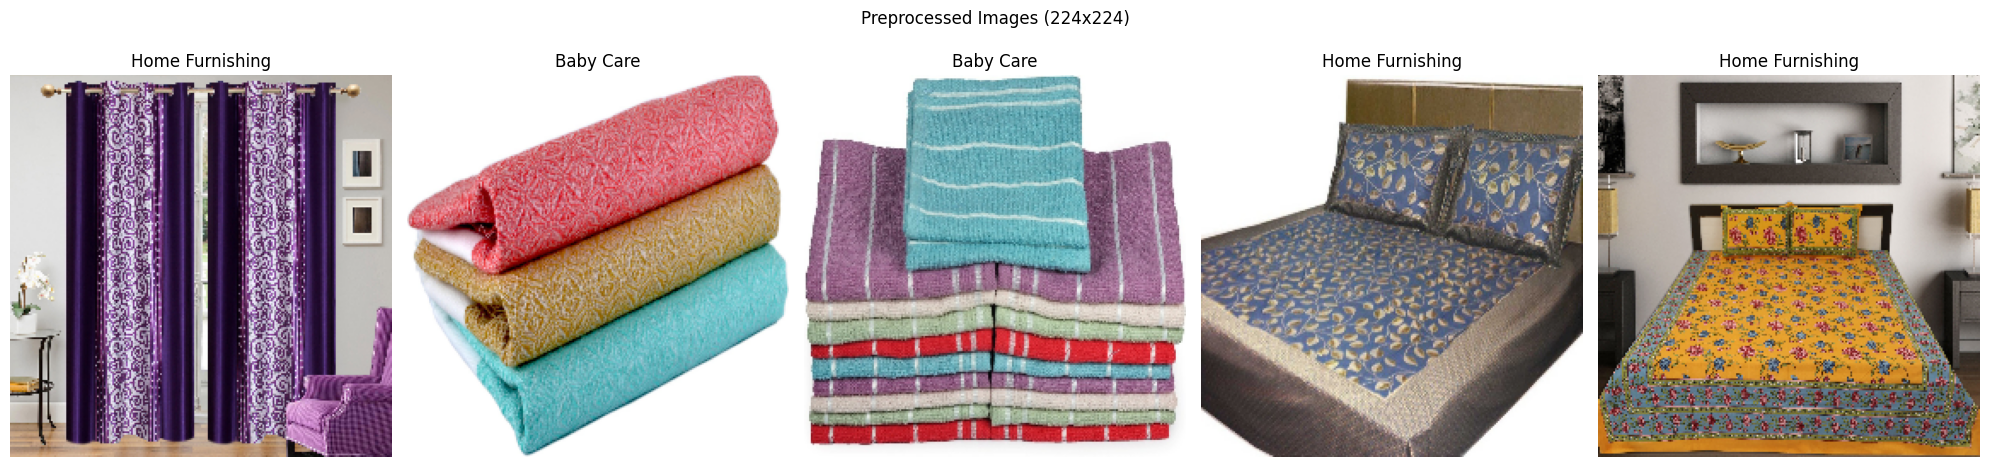

In [23]:
# Display some preprocessed images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, (idx, row) in zip(axes, df_pict.head().iterrows()):
    ax.imshow(row['img_preprocessed'])
    ax.set_title(row['categorie'][:20] + '...' if len(row['categorie']) > 20 else row['categorie'])
    ax.axis('off')
plt.suptitle('Preprocessed Images (224x224)')
plt.tight_layout()
plt.show()

## Feature Extraction - SIFT (Scale-Invariant Feature Transform)

SIFT extracts keypoints and descriptors that are invariant to scale and rotation. We'll use a Bag-of-Visual-Words approach to create fixed-size feature vectors.

In [24]:
from sklearn.cluster import MiniBatchKMeans

# Initialize SIFT detector
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    """Extract SIFT descriptors from an image"""
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    return keypoints, descriptors

# Extract SIFT descriptors from all images
print("Extracting SIFT descriptors...")
all_descriptors = []
image_descriptors = {}

for i, (idx, row) in enumerate(df_pict.iterrows(), 1):
    print(f'\r{i}/{len(df_pict)}', end='')
    img = row['img_preprocessed']
    kp, desc = extract_sift_descriptors(img)
    
    if desc is not None:
        all_descriptors.append(desc)
        image_descriptors[idx] = desc
    else:
        image_descriptors[idx] = np.zeros((1, 128))  # SIFT descriptor size is 128
        
print(f"\nExtracted descriptors from {len(image_descriptors)} images")

Extracting SIFT descriptors...
1050/1050
Extracted descriptors from 1050 images


In [25]:
# Create Bag of Visual Words using K-Means clustering
N_CLUSTERS = 100  # Number of visual words

# Stack all descriptors for clustering
all_desc_stacked = np.vstack([d for d in all_descriptors if d is not None and len(d) > 0])
print(f"Total descriptors for clustering: {all_desc_stacked.shape}")

# Fit K-Means to create visual vocabulary
print("Training visual vocabulary with K-Means...")
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=1000, n_init=3)
kmeans.fit(all_desc_stacked)
print("Visual vocabulary created!")

Total descriptors for clustering: (254887, 128)
Training visual vocabulary with K-Means...
Visual vocabulary created!


In [26]:
def create_bovw_histogram(descriptors, kmeans_model, n_clusters):
    """
    Create Bag-of-Visual-Words histogram for an image
    """
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(n_clusters)
    
    # Predict cluster for each descriptor
    predictions = kmeans_model.predict(descriptors)
    
    # Create histogram
    histogram, _ = np.histogram(predictions, bins=np.arange(n_clusters + 1))
    
    # Normalize histogram
    histogram = histogram.astype(float)
    if histogram.sum() > 0:
        histogram /= histogram.sum()
    
    return histogram

# Create SIFT-BOVW features for all images
print("Creating SIFT-BOVW features...")
sift_features = []
for i, (idx, desc) in enumerate(image_descriptors.items(), 1):
    print(f'\r{i}/{len(image_descriptors)}', end='')
    hist = create_bovw_histogram(desc, kmeans, N_CLUSTERS)
    sift_features.append(hist)

sift_features = np.array(sift_features)
print(f"\nSIFT-BOVW features shape: {sift_features.shape}")

Creating SIFT-BOVW features...
344/1050

ValueError: Buffer dtype mismatch, expected 'const double' but got 'float'

## Feature Extraction - ORB (Oriented FAST and Rotated BRIEF)

ORB is a faster alternative to SIFT, using binary descriptors. We'll also use Bag-of-Visual-Words approach.

In [ ]:
# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=500)

def extract_orb_descriptors(img):
    """Extract ORB descriptors from an image"""
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    return keypoints, descriptors

# Extract ORB descriptors from all images
print("Extracting ORB descriptors...")
all_orb_descriptors = []
orb_image_descriptors = {}

for i, (idx, row) in enumerate(df_pict.iterrows(), 1):
    print(f'\r{i}/{len(df_pict)}', end='')
    img = row['img_preprocessed']
    kp, desc = extract_orb_descriptors(img)
    
    if desc is not None:
        all_orb_descriptors.append(desc.astype(np.float32))
        orb_image_descriptors[idx] = desc.astype(np.float32)
    else:
        orb_image_descriptors[idx] = np.zeros((1, 32), dtype=np.float32)  # ORB descriptor size is 32
        
print(f"\nExtracted ORB descriptors from {len(orb_image_descriptors)} images")

Extracting ORB descriptors...

1/1050
2/1050
3/1050
4/1050
5/1050
6/1050
7/1050
8/1050
9/1050
10/1050
11/1050
12/1050
13/1050
14/1050
15/1050
16/1050
17/1050
18/1050
19/1050
20/1050
21/1050
22/1050
23/1050
24/1050
25/1050
26/1050
27/1050
28/1050
29/1050
30/1050
31/1050
32/1050
33/1050
34/1050
35/1050
36/1050
37/1050
38/1050
39/1050
40/1050
41/1050
42/1050
43/1050
44/1050
45/1050
46/1050
47/1050
48/1050
49/1050
50/1050
51/1050
52/1050
53/1050
54/1050
55/1050
56/1050
57/1050
58/1050
59/1050
60/1050
61/1050
62/1050
63/1050
64/1050
65/1050
66/1050
67/1050
68/1050
69/1050
70/1050
71/1050
72/1050
73/1050
74/1050
75/1050
76/1050
77/1050
78/1050
79/1050
80/1050
81/1050
82/1050
83/1050
84/1050
85/1050


86/1050
87/1050
88/1050
89/1050
90/1050
91/1050
92/1050
93/1050
94/1050
95/1050
96/1050
97/1050
98/1050
99/1050
100/1050
101/1050
102/1050
103/1050
104/1050
105/1050
106/1050
107/1050
108/1050
109/1050
110/1050
111/1050
112/1050
113/1050
114/1050
115/1050
116/1050
117/1050
118/1050
119/1050
120/1050
121/1050
122/1050
123/1050
124/1050
125/1050
126/1050
127/1050
128/1050
129/1050
130/1050
131/1050
132/1050
133/1050
134/1050
135/1050
136/1050
137/1050
138/1050
139/1050
140/1050
141/1050
142/1050
143/1050
144/1050
145/1050
146/1050
147/1050
148/1050
149/1050
150/1050
151/1050
152/1050
153/1050
154/1050
155/1050
156/1050
157/1050
158/1050
159/1050
160/1050
161/1050
162/1050
163/1050
164/1050
165/1050
166/1050
167/1050
168/1050
169/1050
170/1050
171/1050
172/1050
173/1050
174/1050
175/1050
176/1050
177/1050
178/1050
179/1050
180/1050
181/1050
182/1050
183/1050
184/1050
185/1050
186/1050
187/1050
188/1050
189/1050
190/1050
191/1050
192/1050
193/1050
194/1050
195/1050
196/1050
197/1050
198/1


221/1050
222/1050
223/1050
224/1050
225/1050
226/1050
227/1050
228/1050
229/1050
230/1050
231/1050
232/1050
233/1050
234/1050
235/1050
236/1050
237/1050
238/1050
239/1050
240/1050
241/1050
242/1050
243/1050
244/1050
245/1050
246/1050
247/1050
248/1050
249/1050
250/1050
251/1050
252/1050
253/1050
254/1050
255/1050
256/1050
257/1050
258/1050
259/1050
260/1050
261/1050
262/1050
263/1050
264/1050
265/1050
266/1050
267/1050
268/1050
269/1050
270/1050
271/1050
272/1050
273/1050
274/1050
275/1050
276/1050
277/1050
278/1050
279/1050
280/1050
281/1050
282/1050
283/1050
284/1050
285/1050
286/1050
287/1050
288/1050
289/1050
290/1050
291/1050
292/1050
293/1050
294/1050
295/1050
296/1050
297/1050
298/1050
299/1050
300/1050
301/1050
302/1050
303/1050
304/1050
305/1050
306/1050
307/1050
308/1050
309/1050
310/1050
311/1050
312/1050
313/1050
314/1050
315/1050
316/1050
317/1050
318/1050
319/1050
320/1050
321/1050
322/1050
323/1050
324/1050
325/1050
326/1050
327/1050
328/1050
329/1050
330/1050
331/1050



364/1050
365/1050
366/1050
367/1050
368/1050
369/1050
370/1050
371/1050
372/1050
373/1050
374/1050
375/1050
376/1050
377/1050
378/1050
379/1050
380/1050
381/1050
382/1050
383/1050
384/1050
385/1050
386/1050
387/1050
388/1050
389/1050
390/1050
391/1050
392/1050
393/1050
394/1050
395/1050
396/1050
397/1050
398/1050
399/1050
400/1050
401/1050
402/1050
403/1050
404/1050
405/1050
406/1050
407/1050
408/1050
409/1050
410/1050
411/1050
412/1050
413/1050
414/1050
415/1050
416/1050
417/1050
418/1050
419/1050
420/1050
421/1050
422/1050
423/1050
424/1050
425/1050
426/1050
427/1050
428/1050
429/1050
430/1050
431/1050
432/1050
433/1050
434/1050
435/1050
436/1050
437/1050
438/1050
439/1050
440/1050
441/1050
442/1050
443/1050
444/1050
445/1050
446/1050
447/1050
448/1050
449/1050
450/1050
451/1050
452/1050
453/1050
454/1050
455/1050
456/1050
457/1050
458/1050
459/1050
460/1050
461/1050
462/1050
463/1050
464/1050
465/1050
466/1050
467/1050
468/1050
469/1050
470/1050
471/1050
472/1050
473/1050
474/1050



515/1050
516/1050
517/1050
518/1050
519/1050
520/1050
521/1050
522/1050
523/1050
524/1050
525/1050
526/1050
527/1050
528/1050
529/1050
530/1050
531/1050
532/1050
533/1050
534/1050
535/1050
536/1050
537/1050
538/1050
539/1050
540/1050
541/1050
542/1050
543/1050
544/1050
545/1050
546/1050
547/1050
548/1050
549/1050
550/1050
551/1050
552/1050
553/1050
554/1050
555/1050
556/1050
557/1050
558/1050
559/1050
560/1050
561/1050
562/1050
563/1050
564/1050
565/1050
566/1050
567/1050
568/1050
569/1050
570/1050
571/1050
572/1050
573/1050
574/1050
575/1050
576/1050
577/1050
578/1050
579/1050
580/1050
581/1050
582/1050
583/1050
584/1050
585/1050
586/1050
587/1050
588/1050
589/1050
590/1050
591/1050
592/1050
593/1050
594/1050
595/1050
596/1050
597/1050
598/1050
599/1050
600/1050
601/1050
602/1050
603/1050
604/1050
605/1050
606/1050
607/1050
608/1050
609/1050
610/1050
611/1050
612/1050
613/1050
614/1050
615/1050
616/1050
617/1050
618/1050
619/1050
620/1050
621/1050
622/1050
623/1050
624/1050
625/1050



655/1050
656/1050
657/1050
658/1050
659/1050
660/1050
661/1050
662/1050
663/1050
664/1050
665/1050
666/1050
667/1050
668/1050
669/1050
670/1050
671/1050
672/1050
673/1050
674/1050
675/1050
676/1050
677/1050
678/1050
679/1050
680/1050
681/1050
682/1050
683/1050
684/1050
685/1050
686/1050
687/1050
688/1050
689/1050
690/1050
691/1050
692/1050
693/1050
694/1050
695/1050
696/1050
697/1050
698/1050
699/1050
700/1050
701/1050
702/1050
703/1050
704/1050
705/1050
706/1050
707/1050
708/1050
709/1050
710/1050
711/1050
712/1050
713/1050
714/1050
715/1050
716/1050
717/1050
718/1050
719/1050
720/1050
721/1050
722/1050
723/1050
724/1050
725/1050
726/1050
727/1050
728/1050
729/1050
730/1050
731/1050
732/1050
733/1050
734/1050
735/1050
736/1050
737/1050
738/1050
739/1050
740/1050
741/1050
742/1050
743/1050
744/1050
745/1050
746/1050
747/1050
748/1050
749/1050
750/1050
751/1050
752/1050
753/1050
754/1050
755/1050
756/1050
757/1050
758/1050
759/1050
760/1050
761/1050
762/1050
763/1050
764/1050
765/1050



786/1050
787/1050
788/1050
789/1050
790/1050
791/1050
792/1050
793/1050
794/1050
795/1050
796/1050
797/1050
798/1050
799/1050
800/1050
801/1050
802/1050
803/1050
804/1050
805/1050
806/1050
807/1050
808/1050
809/1050
810/1050
811/1050
812/1050
813/1050
814/1050
815/1050
816/1050
817/1050
818/1050
819/1050
820/1050
821/1050
822/1050
823/1050
824/1050
825/1050
826/1050
827/1050
828/1050
829/1050
830/1050
831/1050
832/1050
833/1050
834/1050
835/1050
836/1050
837/1050
838/1050
839/1050
840/1050
841/1050
842/1050
843/1050
844/1050
845/1050
846/1050
847/1050
848/1050
849/1050
850/1050
851/1050
852/1050
853/1050
854/1050
855/1050
856/1050
857/1050
858/1050
859/1050
860/1050
861/1050
862/1050
863/1050
864/1050
865/1050
866/1050
867/1050
868/1050
869/1050
870/1050
871/1050
872/1050
873/1050
874/1050
875/1050
876/1050
877/1050
878/1050
879/1050
880/1050
881/1050
882/1050
883/1050
884/1050
885/1050
886/1050
887/1050
888/1050
889/1050
890/1050
891/1050
892/1050
893/1050
894/1050
895/1050
896/1050



926/1050
927/1050
928/1050
929/1050
930/1050
931/1050
932/1050
933/1050
934/1050
935/1050
936/1050
937/1050
938/1050
939/1050
940/1050
941/1050
942/1050
943/1050
944/1050
945/1050
946/1050
947/1050
948/1050
949/1050
950/1050
951/1050
952/1050
953/1050
954/1050
955/1050
956/1050
957/1050
958/1050
959/1050
960/1050
961/1050
962/1050
963/1050
964/1050
965/1050
966/1050
967/1050
968/1050
969/1050
970/1050
971/1050
972/1050
973/1050
974/1050
975/1050
976/1050
977/1050
978/1050
979/1050
980/1050
981/1050
982/1050
983/1050
984/1050
985/1050
986/1050
987/1050
988/1050
989/1050
990/1050
991/1050
992/1050
993/1050
994/1050
995/1050
996/1050
997/1050
998/1050
999/1050
1000/1050
1001/1050
1002/1050
1003/1050
1004/1050
1005/1050
1006/1050
1007/1050
1008/1050
1009/1050
1010/1050
1011/1050
1012/1050
1013/1050
1014/1050
1015/1050
1016/1050
1017/1050
1018/1050
1019/1050
1020/1050
1021/1050
1022/1050
1023/1050
1024/1050
1025/1050
1026/1050
1027/1050
1028/1050
1029/1050
1030/1050
1031/1050
1032/1050
103

In [ ]:
# Create Bag of Visual Words for ORB
N_CLUSTERS_ORB = 100

# Stack all ORB descriptors for clustering
all_orb_stacked = np.vstack([d for d in all_orb_descriptors if d is not None and len(d) > 0])
print(f"Total ORB descriptors for clustering: {all_orb_stacked.shape}")

# Fit K-Means for ORB vocabulary
print("Training ORB visual vocabulary with K-Means...")
kmeans_orb = MiniBatchKMeans(n_clusters=N_CLUSTERS_ORB, random_state=42, batch_size=1000, n_init=3)
kmeans_orb.fit(all_orb_stacked)

# Create ORB-BOVW features
print("Creating ORB-BOVW features...")
orb_features = []
for i, (idx, desc) in enumerate(orb_image_descriptors.items(), 1):
    print(f'\r{i}/{len(orb_image_descriptors)}', end='')
    hist = create_bovw_histogram(desc, kmeans_orb, N_CLUSTERS_ORB)
    orb_features.append(hist)

orb_features = np.array(orb_features)
print(f"\nORB-BOVW features shape: {orb_features.shape}")

Total ORB descriptors for clustering: (357476, 32)
Training ORB visual vocabulary with K-Means...


Creating ORB-BOVW features...

1/1050
2/1050
3/1050
4/1050
5/1050
6/1050
7/1050
8/1050
9/1050
10/1050
11/1050
12/1050
13/1050
14/1050
15/1050
16/1050
17/1050
18/1050
19/1050
20/1050
21/1050
22/1050
23/1050
24/1050
25/1050
26/1050
27/1050
28/1050
29/1050
30/1050
31/1050
32/1050
33/1050
34/1050
35/1050
36/1050
37/1050
38/1050
39/1050
40/1050
41/1050
42/1050
43/1050
44/1050
45/1050
46/1050
47/1050
48/1050
49/1050
50/1050
51/1050
52/1050
53/1050
54/1050
55/1050
56/1050
57/1050
58/1050
59/1050
60/1050
61/1050
62/1050
63/1050
64/1050
65/1050
66/1050
67/1050
68/1050
69/1050
70/1050
71/1050
72/1050
73/1050
74/1050
75/1050
76/1050
77/1050
78/1050
79/1050
80/1050
81/1050
82/1050
83/1050
84/1050
85/1050
86/1050
87/1050
88/1050
89/1050
90/1050
91/1050
92/1050
93/1050
94/1050
95/1050
96/1050
97/1050
98/1050
99/1050
100/1050
101/1050
102/1050
103/1050
104/1050
105/1050
106/1050
107/1050
108/1050
109/1050
110/1050
111/1050
112/1050
113/1050
114/1050
115/1050
116/1050
117/1050
118/1050
119/1050
120/10

## Feature Extraction - CNN Transfer Learning (VGG16)

We use a pre-trained VGG16 model (trained on ImageNet) to extract deep features from the images. We remove the classification head and use the output of the convolutional layers as our feature representation.

In [ ]:
# Load pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a feature extractor model with Global Average Pooling
feature_extractor = Model(
    inputs=base_model.input,
    outputs=GlobalAveragePooling2D()(base_model.output)
)

print("VGG16 Feature Extractor Summary:")
print(f"Input shape: {feature_extractor.input_shape}")
print(f"Output shape: {feature_extractor.output_shape}")


       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


   16384/58889256 ━━━━━━━━━━━━━━━━━━━━ 3:29 4us/step


   49152/58889256 ━━━━━━━━━━━━━━━━━━━━ 3:10 3us/step


   81920/58889256 ━━━━━━━━━━━━━━━━━━━━ 3:05 3us/step


  131072/58889256 ━━━━━━━━━━━━━━━━━━━━ 2:18 2us/step


  180224/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:59 2us/step


  262144/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:34 2us/step


  393216/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:11 1us/step


  540672/58889256 ━━━━━━━━━━━━━━━━━━━━ 57s 1us/step 


  819200/58889256 ━━━━━━━━━━━━━━━━━━━━ 41s 1us/step


  958464/58889256 ━━━━━━━━━━━━━━━━━━━━ 38s 1us/step


 1736704/58889256 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


 2433024/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


 3792896/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


 5636096/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 


 8044544/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


10190848/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


12566528/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


14958592/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


17072128/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


20004864/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


21807104/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


24117248/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


26427392/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


28655616/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


31481856/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


33374208/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


35512320/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


38191104/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


40230912/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


43098112/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


47030272/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


50880512/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


54820864/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


58728448/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


VGG16 Feature Extractor Summary:
Input shape: (None, 224, 224, 3)
Output shape: (None, 512)


In [ ]:
# Extract VGG16 features from all images
print("Extracting VGG16 features...")

# Prepare images for VGG16 (batch processing)
images_array = np.array([row['img_preprocessed'] for _, row in df_pict.iterrows()])

# Preprocess for VGG16 (expects BGR, specific normalization)
images_preprocessed = preprocess_input(images_array.astype(np.float32))

# Extract features in batches
BATCH_SIZE = 32
vgg_features = []

for i in range(0, len(images_preprocessed), BATCH_SIZE):
    batch = images_preprocessed[i:i+BATCH_SIZE]
    print(f'\rProcessing batch {i//BATCH_SIZE + 1}/{(len(images_preprocessed)-1)//BATCH_SIZE + 1}', end='')
    batch_features = feature_extractor.predict(batch, verbose=0)
    vgg_features.append(batch_features)

vgg_features = np.vstack(vgg_features)
print(f"\nVGG16 features shape: {vgg_features.shape}")

Extracting VGG16 features...



Processing batch 1/33


Processing batch 2/33


Processing batch 3/33


Processing batch 4/33


Processing batch 5/33


Processing batch 6/33


Processing batch 7/33


Processing batch 8/33


Processing batch 9/33


Processing batch 10/33


Processing batch 11/33


Processing batch 12/33


Processing batch 13/33


Processing batch 14/33


Processing batch 15/33


Processing batch 16/33


Processing batch 17/33


Processing batch 18/33


Processing batch 19/33


Processing batch 20/33


Processing batch 21/33


Processing batch 22/33


Processing batch 23/33


Processing batch 24/33


Processing batch 25/33


Processing batch 26/33


Processing batch 27/33


Processing batch 28/33


Processing batch 29/33


Processing batch 30/33


Processing batch 31/33


Processing batch 32/33


Processing batch 33/33


VGG16 features shape: (1050, 512)


# Dimensionality Reduction and Visualization

We'll use both PCA and t-SNE to visualize the extracted features in 2D, colored by product category.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Encode categories for visualization
le = LabelEncoder()
labels = le.fit_transform(df_pict['categorie'])
categories = le.classes_

print(f"Number of categories: {len(categories)}")
print("Categories:", categories)

Number of categories: 7
Categories: ['Baby Care' 'Beauty and Personal Care' 'Computers'
 'Home Decor & Festive Needs' 'Home Furnishing' 'Kitchen & Dining'
 'Watches']


In [ ]:
def plot_2d_features(features_2d, labels, title, label_encoder):
    """
    Plot 2D features colored by category
    """
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='tab10', alpha=0.7, s=30)
    
    # Add legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, label_encoder.classes_, title="Categorie", 
               loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## PCA Visualization

SIFT PCA explained variance ratio: 21.07%


ValueError: 'c' argument has 1050 elements, which is inconsistent with 'x' and 'y' with size 343.

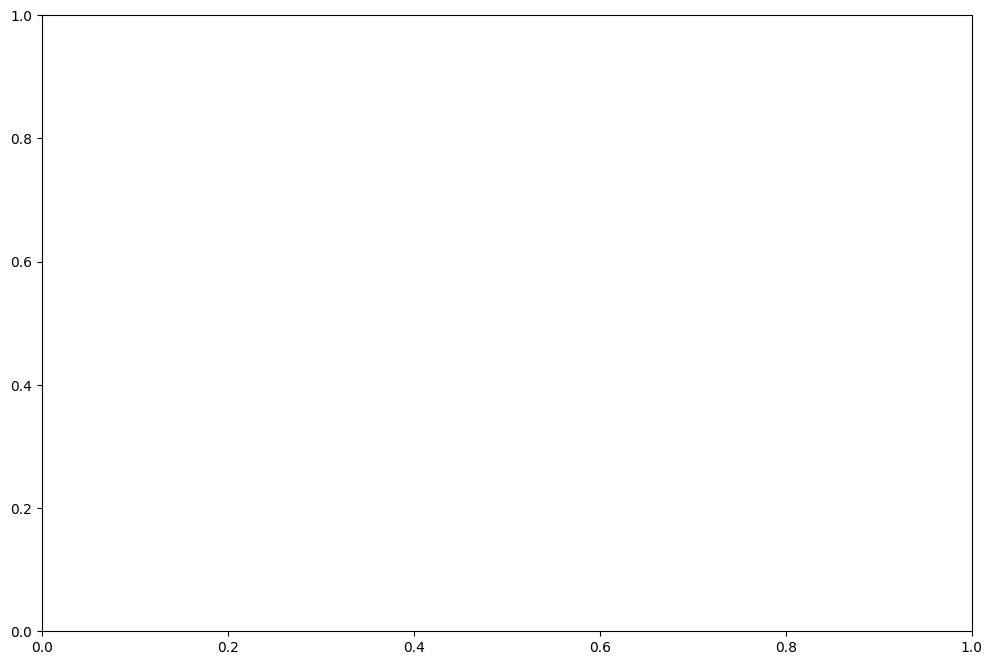

In [ ]:
# PCA for SIFT-BOVW features
pca_sift = PCA(n_components=2)
sift_pca = pca_sift.fit_transform(sift_features)
print(f"SIFT PCA explained variance ratio: {pca_sift.explained_variance_ratio_.sum():.2%}")
plot_2d_features(sift_pca, labels, "SIFT-BOVW Features - PCA 2D Projection", le)

ORB PCA explained variance ratio: 31.96%


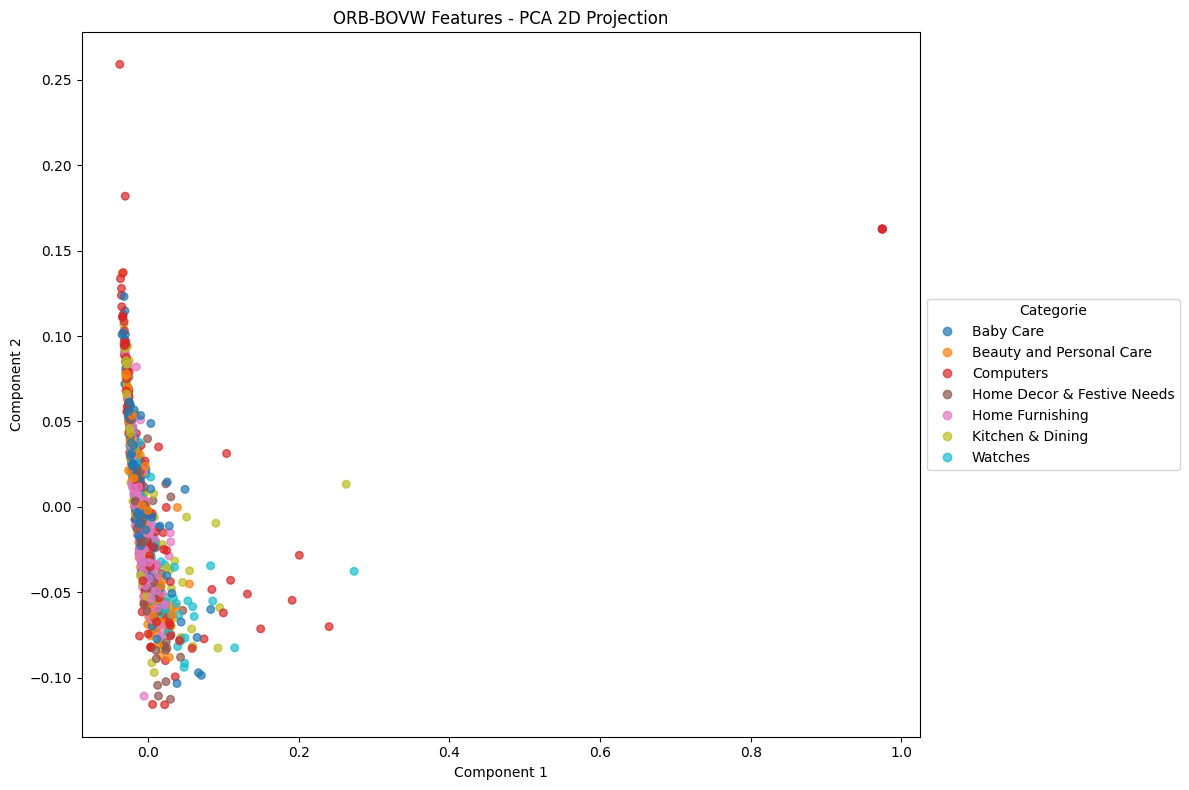

In [ ]:
# PCA for ORB-BOVW features
pca_orb = PCA(n_components=2)
orb_pca = pca_orb.fit_transform(orb_features)
print(f"ORB PCA explained variance ratio: {pca_orb.explained_variance_ratio_.sum():.2%}")
plot_2d_features(orb_pca, labels, "ORB-BOVW Features - PCA 2D Projection", le)

VGG16 PCA explained variance ratio: 20.36%


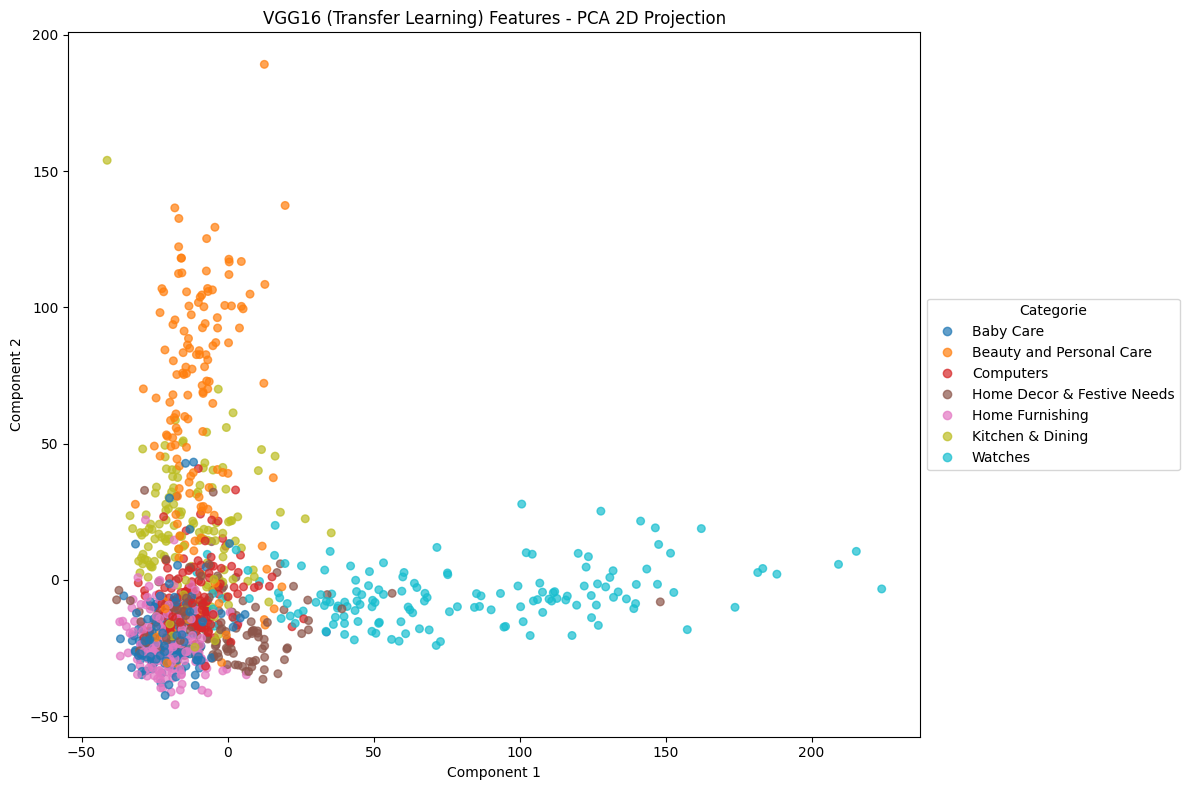

In [ ]:
# PCA for VGG16 features
pca_vgg = PCA(n_components=2)
vgg_pca = pca_vgg.fit_transform(vgg_features)
print(f"VGG16 PCA explained variance ratio: {pca_vgg.explained_variance_ratio_.sum():.2%}")
plot_2d_features(vgg_pca, labels, "VGG16 (Transfer Learning) Features - PCA 2D Projection", le)

## t-SNE Visualization

t-SNE is better at preserving local structure and often produces clearer clusters than PCA.

In [ ]:
# t-SNE for SIFT-BOVW features
print("Computing t-SNE for SIFT features...")
tsne_sift = TSNE(n_components=2, random_state=42, perplexity=30)
sift_tsne = tsne_sift.fit_transform(sift_features)
plot_2d_features(sift_tsne, labels, "SIFT-BOVW Features - t-SNE 2D Projection", le)

Computing t-SNE for SIFT features...


AttributeError: 'list' object has no attribute 'shape'

Computing t-SNE for ORB features...


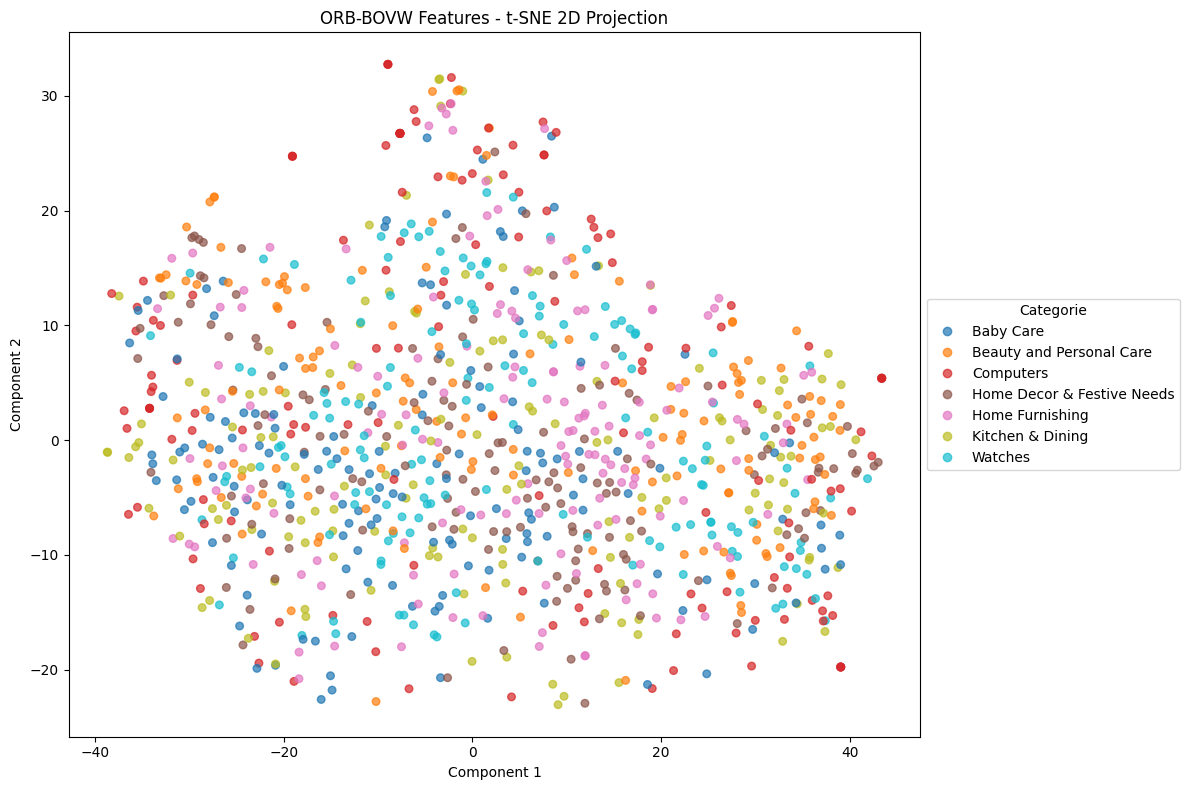

In [ ]:
# t-SNE for ORB-BOVW features
print("Computing t-SNE for ORB features...")
tsne_orb = TSNE(n_components=2, random_state=42, perplexity=30)
orb_tsne = tsne_orb.fit_transform(orb_features)
plot_2d_features(orb_tsne, labels, "ORB-BOVW Features - t-SNE 2D Projection", le)

Computing t-SNE for VGG16 features...


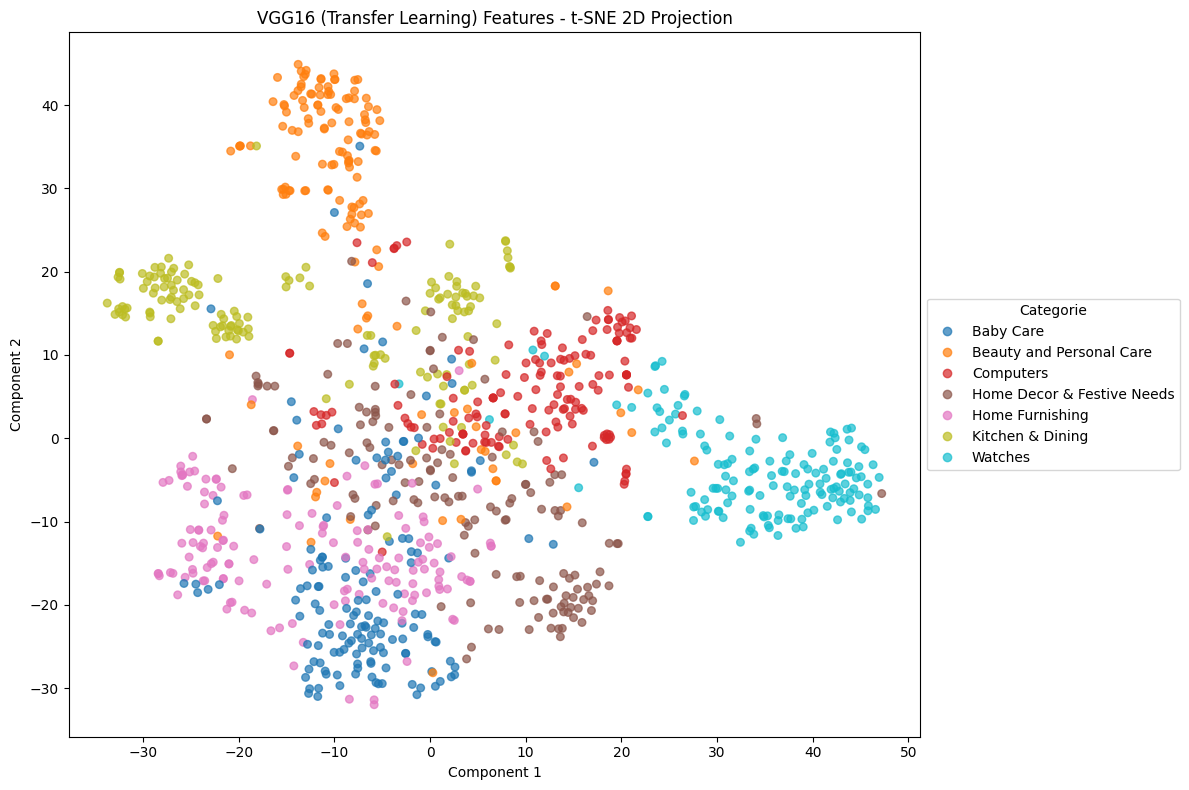

In [ ]:
# t-SNE for VGG16 features
print("Computing t-SNE for VGG16 features...")
tsne_vgg = TSNE(n_components=2, random_state=42, perplexity=30)
vgg_tsne = tsne_vgg.fit_transform(vgg_features)
plot_2d_features(vgg_tsne, labels, "VGG16 (Transfer Learning) Features - t-SNE 2D Projection", le)

## Quantitative Clustering Validation

We use K-Means clustering to group images and compare the resulting clusters with the actual product categories using various metrics:
- **ARI (Adjusted Rand Index)**: Measures similarity between two clusterings, adjusted for chance
- **NMI (Normalized Mutual Information)**: Measures the mutual dependence between clusterings
- **Homogeneity**: Whether clusters contain only members of a single class
- **Completeness**: Whether all members of a class are assigned to the same cluster

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

def evaluate_clustering(features, true_labels, feature_name, n_clusters=None):
    """
    Perform K-Means clustering and evaluate against true labels
    """
    if n_clusters is None:
        n_clusters = len(np.unique(true_labels))
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    predicted_clusters = kmeans.fit_predict(features)
    
    # Calculate metrics
    ari = adjusted_rand_score(true_labels, predicted_clusters)
    nmi = normalized_mutual_info_score(true_labels, predicted_clusters)
    homogeneity = homogeneity_score(true_labels, predicted_clusters)
    completeness = completeness_score(true_labels, predicted_clusters)
    v_measure = v_measure_score(true_labels, predicted_clusters)
    
    return {
        'Feature': feature_name,
        'ARI': ari,
        'NMI': nmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    }

# Number of clusters equals number of categories
n_categories = len(np.unique(labels))
print(f"Number of categories: {n_categories}")

# Evaluate all image feature extraction methods
results = []
results.append(evaluate_clustering(sift_features, labels, 'SIFT-BOVW', n_categories))
results.append(evaluate_clustering(orb_features, labels, 'ORB-BOVW', n_categories))
results.append(evaluate_clustering(vgg_features, labels, 'VGG16 (CNN)', n_categories))

# Create results dataframe
df_results = pd.DataFrame(results)
df_results = df_results.set_index('Feature')
print("\n=== Image Feature Clustering Evaluation ===")
df_results

Number of categories: 7


ValueError: Found input variables with inconsistent numbers of samples: [1050, 343]

NameError: name 'df_results' is not defined

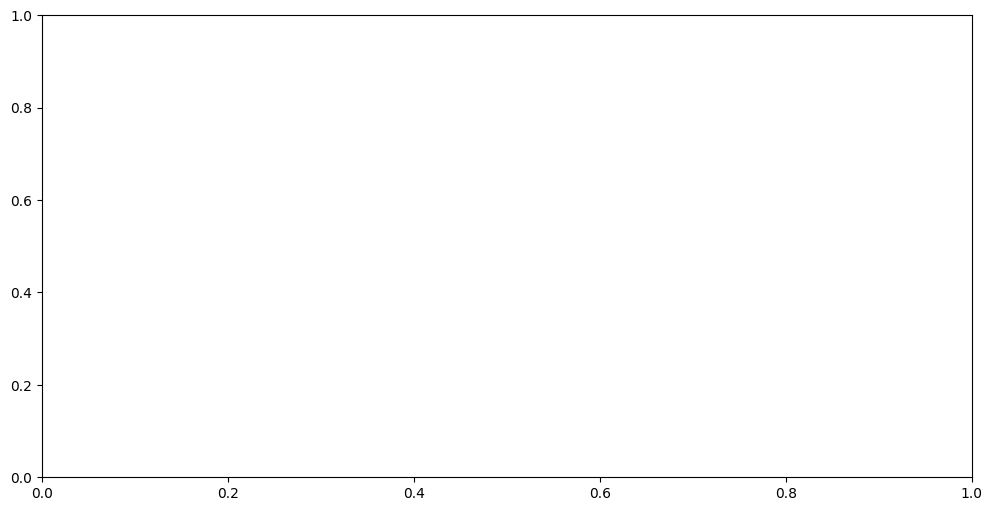

In [ ]:
# Visualize clustering metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))
df_results.plot(kind='bar', ax=ax)
plt.title('Image Feature Extraction Methods - Clustering Metrics Comparison')
plt.xlabel('Feature Extraction Method')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Higher values indicate better alignment between clusters and true categories")
print("- ARI: -1 to 1, 0 is random, 1 is perfect agreement")
print("- NMI: 0 to 1, higher is better")
print(f"\nBest performing method: {df_results['ARI'].idxmax()} with ARI = {df_results['ARI'].max():.4f}")

## Conclusion - Image Feature Extraction Feasibility

Based on the 2D visualizations and clustering metrics:

1. **VGG16 (CNN Transfer Learning)** provides the best feature representation for product categorization, with clearer cluster separation in the visualizations.

2. **Traditional methods (SIFT/ORB)** capture local patterns but may not generalize as well for semantic product categorization.

3. **Feasibility**: The clustering results suggest that image-based automatic classification IS feasible, particularly using deep learning features.

4. **Recommendation**: Use CNN-based features (VGG16 or similar) for the image modality in a multimodal classification system.